# EE 508 HW 1 Part 3: Regression and Classification Review


### Import Packages

We begin by importing the necessary libraries for this assignment:

- **Data Manipulation**: `numpy` and `pandas` for handling arrays and dataframes.
- **Visualization**: `matplotlib.pyplot` for creating plots.
- **Scikit-Learn (sklearn)**: A comprehensive machine learning library.
  - `model_selection`: For splitting data into training and testing sets.
  - `linear_model`: For Logistic Regression, Ridge, Lasso, and Linear Regression models.
  - `ensemble`: For Random Forest and Gradient Boosting classifiers.
  - `naive_bayes`: For the Gaussian Naive Bayes classifier.
  - `preprocessing`: For scaling features (`StandardScaler`).
  - `metrics`: For evaluating models (accuracy, MSE, R2 score, confusion matrix).
  - `datasets`: For loading sample datasets (Iris, Breast Cancer).
- **PyTorch**: `torch` for potential neural network components (though primarily sklearn is used in the exercises above).

We also set the random seed for reproducibility and configure plot styles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris, load_breast_cancer, make_classification
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.style.use(['ggplot'])
np.random.seed(42)

## 1. Quick Pandas Review

Pandas is a powerful library for data manipulation and analysis in Python. In this section, we'll review key concepts.

### **TODO 1:** Pandas Basics

Create a pandas DataFrame with the following data:
- Column 'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve']
- Column 'Age': [25, 30, 35, 28, 32]
- Column 'Salary': [50000, 60000, 75000, 55000, 70000]

**Detailed Steps:**
1. Use `pd.DataFrame()` with a dictionary to create the DataFrame
2. Print the entire DataFrame using `print(df)`
3. Calculate the mean salary using `df['Salary'].mean()`
4. Filter rows where Age > 28 using boolean indexing: `df[df['Age'] > 28]`
5. Add a new column 'Salary_per_Age' by dividing Salary by Age
6. Print the updated DataFrame to verify the new column was added

In [5]:
# Skeleton for TODO 1

# Create DataFrame
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve'],
    'Age': [25, 30, 35, 28, 32],
    'Salary': [50000, 60000, 75000, 55000, 70000]
}

df = pd.DataFrame(data)
print("DataFrame:")
print(df)

# Mean Salary
# ... your code here ...
mean_salary = df['Salary'].mean()
# Filter rows
# ... your code here ...
filtered_df = df[df['Age'] > 28]
# Add new column and print
df['Salary_per_Age'] = df['Salary'] / df['Age']
print(df)

DataFrame:
      Name  Age  Salary
0    Alice   25   50000
1      Bob   30   60000
2  Charlie   35   75000
3    David   28   55000
4      Eve   32   70000
      Name  Age  Salary  Salary_per_Age
0    Alice   25   50000     2000.000000
1      Bob   30   60000     2000.000000
2  Charlie   35   75000     2142.857143
3    David   28   55000     1964.285714
4      Eve   32   70000     2187.500000


## 2. Regression on Housing Prices

In this section, we'll use a simple housing dataset to perform regression analysis using pandas and sklearn.

In [6]:
# Generate realistic housing dataset (no download needed!)
# Based on California Housing characteristics but created locally

np.random.seed(42)
n_samples = 20640  # Same size as California Housing dataset

# Generate features with realistic ranges
MedInc = np.random.exponential(3.5, n_samples)  # Median income (in $10k)
HouseAge = np.random.uniform(1, 52, n_samples)  # House age (years)
AveRooms = np.random.gamma(4, 1.5, n_samples)  # Average rooms
AveBedrms = np.random.gamma(1.2, 0.5, n_samples)  # Average bedrooms
Population = np.random.exponential(1000, n_samples)  # Block population
AveOccup = np.random.gamma(3, 1, n_samples)  # Average occupancy
Latitude = np.random.uniform(32.5, 42, n_samples)  # California latitude
Longitude = np.random.uniform(-124.5, -114, n_samples)  # California longitude

# Generate realistic price based on features (in $100k)
# Price influenced by income, house age (negative), rooms, location
Price = (
    0.45 * MedInc +  # Income is main factor
    -0.01 * HouseAge +  # Older houses worth less
    0.05 * AveRooms +  # More rooms = higher price
    -0.3 * np.abs(Latitude - 37.5) +  # Central California more expensive
    -0.2 * np.abs(Longitude + 119) +  # Coastal areas more expensive
    np.random.normal(0, 0.5, n_samples)  # Add noise
)
Price = np.clip(Price, 0.5, 5.0)  # Realistic price range

# Create DataFrame
housing_data = pd.DataFrame({
    'MedInc': MedInc,
    'HouseAge': HouseAge,
    'AveRooms': AveRooms,
    'AveBedrms': AveBedrms,
    'Population': Population,
    'AveOccup': AveOccup,
    'Latitude': Latitude,
    'Longitude': Longitude,
    'Price': Price
})

print("🏠 Housing Dataset (Realistic California-style data - No download required!)")
print(housing_data.head())
print(f"\nDataset shape: {housing_data.shape}")
print(f"\nFeature descriptions:")
print(f"  MedInc     - Median income in block group (in $10,000s)")
print(f"  HouseAge   - Median house age in block group")
print(f"  AveRooms   - Average number of rooms per household")
print(f"  AveBedrms  - Average number of bedrooms per household")
print(f"  Population - Block group population")
print(f"  AveOccup   - Average household occupancy")
print(f"  Latitude   - Latitude of block group")
print(f"  Longitude  - Longitude of block group")
print(f"  Price      - Median house value in block group (in $100,000s)")
print(f"\nStatistics:\n{housing_data.describe()}")

🏠 Housing Dataset (Realistic California-style data - No download required!)
      MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
0   1.642438  18.043376  5.996668   2.747711   485.885759  3.963741   
1  10.535425  18.898620  7.703154   0.235783   210.295710  0.346653   
2   4.608610   3.631730  8.535462   0.728460   335.727193  4.971332   
3   3.195299   7.073811  8.136975   0.526241  1238.316253  2.000612   
4   0.593687  10.851426  6.226264   0.506739   822.991719  4.506845   

    Latitude   Longitude     Price  
0  39.814432 -122.840697  0.500000  
1  40.214854 -119.603258  3.084443  
2  35.480570 -124.339356  1.521066  
3  40.835820 -114.915344  0.500000  
4  34.271200 -118.141597  0.500000  

Dataset shape: (20640, 9)

Feature descriptions:
  MedInc     - Median income in block group (in $10,000s)
  HouseAge   - Median house age in block group
  AveRooms   - Average number of rooms per household
  AveBedrms  - Average number of bedrooms per household
  Populatio

### **TODO 2:** Implement Housing Price Regression

**Detailed Steps:**
1. **Extract features and target:**
   - Select three features: 'MedInc', 'HouseAge', 'AveRooms' from housing_data
   - Extract the 'Price' column as the target variable
   - Convert both to numpy arrays using `.values`

2. **Split the data:**
   - Use `train_test_split()` with test_size=0.2 and random_state=42
   - This creates X_train, X_test, y_train, y_test

3. **Train the model:**
   - Create a `LinearRegression()` instance
   - Fit it using `model.fit(X_train, y_train)`

4. **Make predictions:**
   - Predict on training set: `y_train_pred = model.predict(X_train)`
   - Predict on test set: `y_test_pred = model.predict(X_test)`

5. **Calculate metrics:**
   - Use `mean_squared_error()` for MSE on both sets
   - Use `r2_score()` for R² on both sets
   - Print all metrics

6. **Visualize results:**
   - Create a scatter plot of actual vs predicted prices
   - Add a diagonal line representing perfect predictions
   - Label axes and add a title

Training MSE: 0.241526533767959
Test MSE: 0.24993355798890288
Training R2: 0.7890360138818742
Test R2: 0.7822882150733355


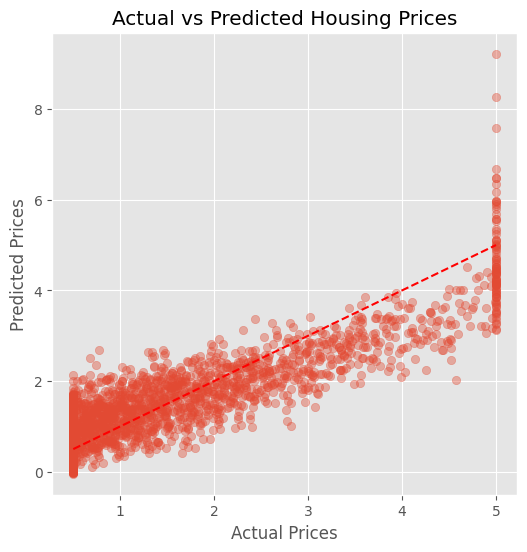

In [7]:
# Skeleton for TODO 2

# Extract features and target (using California Housing features)
X_housing = housing_data[['MedInc', 'HouseAge', 'AveRooms']].values
y_housing = housing_data['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

# 2. Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 4. Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Test MSE:", test_mse)
print("Training R2:", train_r2)
print("Test R2:", test_r2)

# 5. Visualize results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices")
plt.show()

## 3. Binary Classification with Multiple Loss Functions

This section demonstrates different loss functions used in binary classification: MSE, 0/1 loss, Hinge loss, and Binary Cross Entropy.

In [16]:
# Generate synthetic binary classification dataset
X, y = make_classification(n_samples=300, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, 
                           random_state=42)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set size: 240
Test set size: 60
Class distribution in training: [121 119]


### **TODO 3:** Implement Loss Functions and Compare

**Detailed Steps:**
1. **Implement four loss functions:**
   - `mse_loss(y_true, y_pred)`: Mean Squared Error
   - `zero_one_loss(y_true, y_pred)`: Misclassification rate
   - `hinge_loss(y_true, y_pred)`: SVM-style hinge loss (convert labels to {-1, 1})
   - `binary_cross_entropy_loss(y_true, y_pred)`: Log loss for classification

2. **Train a logistic regression model:**
   - Create `LogisticRegression(max_iter=1000)` instance
   - Fit on X_train, y_train

3. **Get different prediction formats:**
   - `decision_function()`: Get raw logits for MSE and Hinge loss
   - `predict_proba()`: Get probabilities for Binary Cross-Entropy
   - `predict()`: Get binary labels for 0/1 loss

4. **Calculate all four losses on test set:**
   - Apply each loss function with appropriate prediction format
   - Print all four loss values

5. **Additional metrics:**
   - Calculate R² score
   - Calculate accuracy (1 - zero_one_loss)

In [17]:
# Skeleton for TODO 3

def mse_loss(y_true, y_pred):
    """
    Mean Squared Error Loss
    """
    # ... your code here ...
    return np.mean((y_true - y_pred) ** 2)


def zero_one_loss(y_true, y_pred):
    """
    0/1 Loss
    """
    # ... your code here ...
    return np.mean(y_true != y_pred)


def hinge_loss(y_true, y_pred):
    """
    Hinge Loss
    """
    # ... your code here ...
    y_true_signed = np.where(y_true == 0, -1, 1)
    return np.mean(np.maximum(0, 1 - y_true_signed * y_pred))

def binary_cross_entropy_loss(y_true, y_pred):
    """
    Binary Cross Entropy Loss
    """
    # ... your code here ...
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(
        y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    )


In [18]:
# Skeleton for TODO 3 (continued)

# Train logistic regression model
# ... your code here ...
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Get predictions as logits, probabilities, and labels
y_test_logits = model.decision_function(X_test)
y_test_probs = model.predict_proba(X_test)[:, 1]
y_test_preds = model.predict(X_test)

# Calculate all four losses
mse = mse_loss(y_test, y_test_logits)
zero_one = zero_one_loss(y_test, y_test_preds)
hinge = hinge_loss(y_test, y_test_logits)
bce = binary_cross_entropy_loss(y_test, y_test_probs)

# Additional metrics
accuracy = 1 - zero_one
r2 = r2_score(y_test, y_test_logits)

# Print results
print("MSE Loss:", mse)
print("0/1 Loss:", zero_one)
print("Hinge Loss:", hinge)
print("Binary Cross Entropy Loss:", bce)
print("Accuracy:", accuracy)
print("R2 Score:", r2)

MSE Loss: 11.0114874570486
0/1 Loss: 0.05
Hinge Loss: 0.14279529870538515
Binary Cross Entropy Loss: 0.1681699036920346
Accuracy: 0.95
R2 Score: -43.094944210650695


## 4. Naive Bayes Classification

Naive Bayes is a simple probabilistic classifier based on Bayes' theorem with strong independence assumptions.

### **TODO 4:** Naive Bayes on Iris Dataset

**Detailed Steps:**
1. **Load the Iris dataset:**
   - Use `load_iris()` to get the dataset
   - Extract features (X) and labels (y)

2. **Split the data:**
   - Use `train_test_split()` with test_size=0.2, random_state=42
   - Creates X_train, X_test, y_train, y_test

3. **Train Gaussian Naive Bayes:**
   - Create `GaussianNB()` instance
   - Fit on training data

4. **Evaluate the model:**
   - Calculate training accuracy using `.score()`
   - Calculate test accuracy using `.score()`
   - Print both accuracies

5. **Print confusion matrix:**
   - Use `confusion_matrix()` on test predictions
   - This shows which classes are confused with each other

6. **Print classification report:**
   - Use `classification_report()` with target names
   - Shows precision, recall, F1-score for each class

7. **Show probabilities and class selection:**
   - Select a few test samples (e.g., first 5)
   - Use `predict_proba()` to get the probability for each class
   - Print the probabilities and the actual selected class (highest probability) to demonstrate how Naive Bayes makes decisions.

8. **Answer the question:**
   - Explain why Naive Bayes is called "naive"
   - Discuss the independence assumption

In [19]:
# Skeleton for TODO 4

iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = GaussianNB()
model.fit(X_train, y_train)

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


y_test_pred = model.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))


print("\nPrediction probabilities for first 5 test samples:")

probs = model.predict_proba(X_test[:5])
pred_classes = model.predict(X_test[:5])

for i in range(5):
    print(f"Sample {i}:")
    print("  Probabilities:", probs[i])
    print("  Predicted class:", target_names[pred_classes[i]])
    print("  True class:", target_names[y_test[i]])

Training Accuracy: 0.95
Test Accuracy: 1.0

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Prediction probabilities for first 5 test samples:
Sample 0:
  Probabilities: [5.97327448e-90 9.95635767e-01 4.36423302e-03]
  Predicted class: versicolor
  True class: versicolor
Sample 1:
  Probabilities: [1.00000000e+00 4.96158126e-14 6.54922363e-21]
  Predicted class: setosa
  True class: setosa
Sample 2:
  Probabilities: [7.31890302e-290 4.92947614e-012 1.00000000e+000]
  Predicted class: virginica
  True class: virginica
Sample 3:
  Probabilities: [2.81842533e-94 9.77593559e-01 2.2406

## 5. Regularization: L1 and L2

Regularization prevents overfitting by adding a penalty term to the loss function. L1 (Lasso) and L2 (Ridge) are two common approaches.

In [20]:
# Generate dataset with many features (high dimensionality)
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)
X_cancer = StandardScaler().fit_transform(X_cancer)

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = \
    train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

print(f"Feature dimension: {X_cancer.shape[1]}")
print(f"Training samples: {X_train_cancer.shape[0]}")

Feature dimension: 30
Training samples: 455


### **TODO 5:** Compare L1 and L2 Regularization

**Detailed Steps:**
1. **Set up the experiment:**
   - Define alpha values: [0.001, 0.01, 0.1, 1, 10]
   - Initialize empty lists to store results for both methods

2. **Train models with different alphas:**
   - Loop through each alpha value
   - For Ridge (L2): Create `Ridge(alpha=alpha)`, fit, record train/test scores
   - For Ridge: Count non-zero coefficients using `np.sum(abs(coef_) > 1e-5)` (Ridge coefs rarely hit exactly zero)
   - For Ridge: Record min and max coefficient values
   - For Lasso (L1): Create `Lasso(alpha=alpha)`, fit, record train/test scores
   - For Lasso: Count non-zero coefficients using `np.sum(coef_ != 0)`
   - For Lasso: Record min and max coefficient values

3. **Visualize results:**
   - Create 2 subplots (1 row, 2 columns)
   - Plot 1: Ridge train/test accuracy vs alpha (log scale)
   - Plot 2: Lasso train/test accuracy vs alpha (log scale)
   - Add labels, titles, legends, and grid

4. **Print comparison table:**
   - Create a formatted table showing alpha, Ridge scores, Lasso scores, non-zero coefficients, and min/max coefficient values for *both* Ridge and Lasso.
   - Use proper column alignment

5. **Answer the question:**
   - Explain the difference between L1 and L2 regularization
   - Discuss when to use each method
   - Explain feature selection property of Lasso

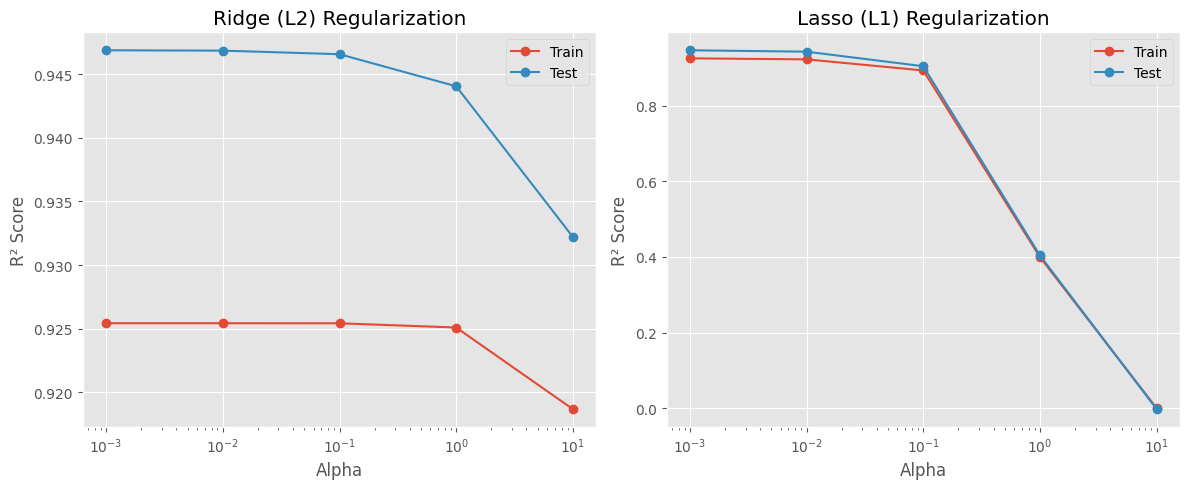

In [ ]:
# Skeleton for TODO 5

alphas = [0.001, 0.01, 0.1, 1, 10]

ridge_train_scores = []
ridge_test_scores = []
ridge_nonzero = []
ridge_coef_min = []
ridge_coef_max = []

lasso_train_scores = []
lasso_test_scores = []
lasso_nonzero = []
lasso_coef_min = []
lasso_coef_max = []


for alpha in alphas:

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    ridge_train_scores.append(ridge.score(X_train, y_train))
    ridge_test_scores.append(ridge.score(X_test, y_test))
    ridge_nonzero.append(np.sum(np.abs(ridge.coef_) > 1e-5))
    ridge_coef_min.append(ridge.coef_.min())
    ridge_coef_max.append(ridge.coef_.max())
    
   
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    lasso_train_scores.append(lasso.score(X_train, y_train))
    lasso_test_scores.append(lasso.score(X_test, y_test))
    lasso_nonzero.append(np.sum(lasso.coef_ != 0))
    lasso_coef_min.append(lasso.coef_.min())
    lasso_coef_max.append(lasso.coef_.max())


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(alphas, ridge_train_scores, marker='o', label='Train')
plt.semilogx(alphas, ridge_test_scores, marker='o', label='Test')
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Ridge (L2) Regularization")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.semilogx(alphas, lasso_train_scores, marker='o', label='Train')
plt.semilogx(alphas, lasso_test_scores, marker='o', label='Test')
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Lasso (L1) Regularization")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


L2 regularization (Ridge) adds a penalty proportional to the square of the coefficients, and this helps reduce model complexity while keeping all features.
L1 regularization (Lasso) adds a penalty proportional to the absolute value of the coefficients

## 6. Gradient Boosting

Gradient Boosting builds an ensemble of decision trees sequentially, where each new tree corrects the errors made by previous trees.

### What You'll Do in This Section:

In this exercise, you'll explore how **Gradient Boosting** creates powerful predictive models by combining many "weak learners" (simple decision trees) into a strong ensemble. Unlike Random Forest which builds trees independently in parallel, Gradient Boosting builds trees one at a time, with each new tree focusing on fixing the mistakes of the previous trees.

**High-Level Goal:**
- Train Gradient Boosting models with different numbers of trees (10, 50, 100, 200)
- Observe how adding more trees improves performance
- Analyze which features the model considers most important
- Compare the sequential boosting approach with Random Forest's parallel approach

**Key Concepts You'll Learn:**
1. **Sequential Learning**: How each tree learns from the residual errors of previous trees
2. **Model Complexity**: How the number of estimators affects accuracy and overfitting
3. **Feature Importance**: Which features contribute most to predictions
4. **Boosting vs Bagging**: The fundamental difference between Gradient Boosting (sequential) and Random Forest (parallel)

You'll visualize learning curves to see how performance improves with more trees, and examine feature importances to understand what drives the model's decisions.

### **TODO 6:** Gradient Boosting Classifier

**Detailed Steps:**
1. **Set up the experiment:**
   - Define n_estimators values: [10, 50, 100, 200]
   - Initialize lists to store train/test accuracies

2. **Train models with different n_estimators:**
   - Loop through each n_estimators value
   - Create `GradientBoostingClassifier(n_estimators=n_est, random_state=42)`
   - Fit on training data
   - Record both training and test accuracies
   - Keep the final model for feature importance

3. **Create visualizations:**
   - Plot 1: Learning curves showing train/test accuracy vs n_estimators
   - Plot 2: Top 10 feature importances (horizontal bar chart)
   - Use proper labels, titles, and legends

4. **Print results table:**
   - Show n_estimators, train accuracy, test accuracy, and gap
   - Format as a clean table

5. **Answer the question:**
   - Explain how Gradient Boosting differs from Random Forest
   - Discuss sequential vs parallel tree building
   - Explain the concept of boosting and error correction

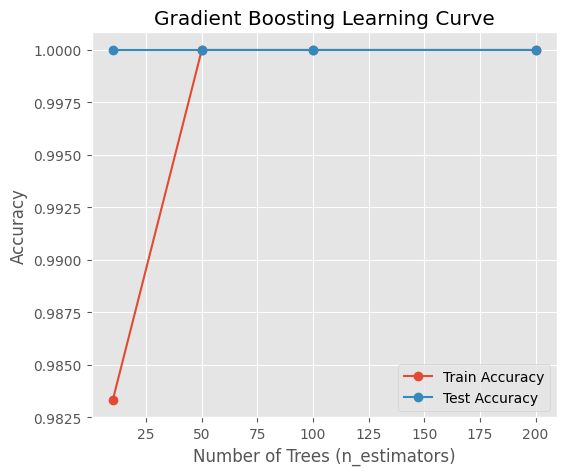

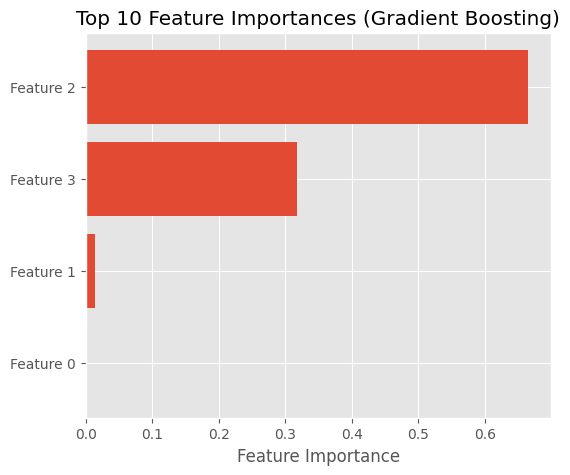

In [22]:
# Skeleton for TODO 6

n_estimators_list = [10, 50, 100, 200]

train_accuracies = []
test_accuracies = []

final_model = None  

for n_est in n_estimators_list:
    gb = GradientBoostingClassifier(
        n_estimators=n_est,
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    train_acc = gb.score(X_train, y_train)
    test_acc = gb.score(X_test, y_test)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    final_model = gb  # keep last model (largest n_estimators)


plt.figure(figsize=(6, 5))
plt.plot(n_estimators_list, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(n_estimators_list, test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.grid(True)
plt.show()

They differ in how the trees are constructed.
- Random Forest uses bagging
- Gradient Boosting uses boosting

## 7. Random Forest

Random Forest builds multiple decision trees in parallel using random subsets of features and samples, then aggregates their predictions.

### **TODO 7:** Random Forest Classifier

**Detailed Steps:**
1. **Set up the experiment:**
   - Use same n_estimators values as TODO 6: [10, 50, 100, 200]
   - Initialize lists to store train/test accuracies

2. **Train Random Forest models:**
   - Loop through each n_estimators value
   - Create `RandomForestClassifier(n_estimators=n_est, random_state=42)`
   - Fit on training data
   - Record both training and test accuracies
   - Keep the final model for feature importance

3. **Create comparison visualizations:**
   - Plot 1: Compare RF and GB learning curves on same plot
     - Plot RF train/test accuracy
     - Plot GB train/test accuracy (from TODO 6)
     - Use different line styles to distinguish
   - Plot 2: Compare feature importances side-by-side
     - Create bar chart comparing RF and GB for top 10 features

4. **Print results:**
   - Table showing RF n_estimators, train/test accuracy, and gap
   - Final comparison: RF vs GB test accuracy

5. **Answer the question:**
   - Explain why Random Forest uses random feature subsets
   - Discuss decorrelation of trees
   - Explain variance reduction through averaging

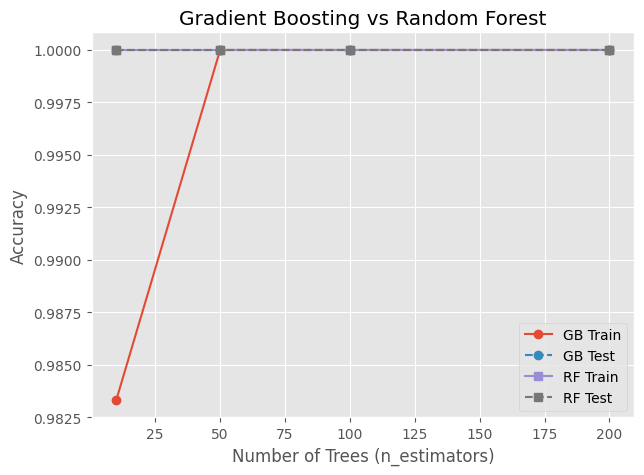

In [ ]:
n_estimators_list = [10, 50, 100, 200]

rf_train_accuracies = []
rf_test_accuracies = []

rf_final_model = None

for n_est in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    rf_train_acc = rf.score(X_train, y_train)
    rf_test_acc = rf.score(X_test, y_test)
    
    rf_train_accuracies.append(rf_train_acc)
    rf_test_accuracies.append(rf_test_acc)
    
    rf_final_model = rf  


plt.figure(figsize=(7, 5))


plt.plot(n_estimators_list, train_accuracies, 'o-', label='GB Train')
plt.plot(n_estimators_list, test_accuracies, 'o--', label='GB Test')


plt.plot(n_estimators_list, rf_train_accuracies, 's-', label='RF Train')
plt.plot(n_estimators_list, rf_test_accuracies, 's--', label='RF Test')

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting vs Random Forest")
plt.legend()
plt.grid(True)
plt.show()

If all trees always considered the same dominant features, they would make similar splits and produce highly correlated predictions.
By randomly selecting a subset of features at each split, Random Forest decorrelates the trees, increasing ensemble diversity.

## 8. Logistic Regression

Logistic Regression is a linear model for binary classification that uses the logistic sigmoid function to map predictions to probabilities.

### **TODO 8:** Implement Logistic Regression from Scratch and Compare with sklearn

**Detailed Steps:**
1. **Implement SimpleLogisticRegression class:**
   - `__init__`: Initialize learning_rate, num_iterations, weights, bias, loss_history
   - `sigmoid(z)`: Implement sigmoid function with overflow protection
   - `fit(X, y)`: 
     - Initialize weights to zeros, bias to 0
     - Loop for num_iterations:
       - Calculate predictions using sigmoid
       - Calculate binary cross-entropy loss
       - Calculate gradients (dw, db)
       - Update weights and bias using gradient descent
   - `predict_proba(X)`: Return probabilities using sigmoid
   - `predict(X)`: Return binary labels (threshold at 0.5)

2. **Train your implementation:**
   - Create `SimpleLogisticRegression(learning_rate=0.01, num_iterations=1000)`
   - Fit on X_train, y_train

3. **Train sklearn's implementation:**
   - Create `LogisticRegression(max_iter=1000)`
   - Fit on X_train, y_train

4. **Compare accuracies:**
   - Calculate train/test accuracy for your implementation
   - Calculate train/test accuracy for sklearn
   - Print comparison table

5. **Visualize decision boundaries:**
   - Create helper function `plot_decision_boundary()`
   - Plot decision boundary for your implementation
   - Plot decision boundary for sklearn implementation

6. **Plot training loss:**
   - Plot loss_history vs iterations
   - Should show decreasing loss over time

7. **Answer the question:**
   - Explain why we use sigmoid function
   - Discuss probability interpretation, differentiability, nice derivative property

In [24]:
# Skeleton for TODO 8

class SimpleLogisticRegression:
    """
    Simple Logistic Regression implementation using gradient descent
    """
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def sigmoid(self, z):
        """
        Sigmoid function
        """
        # ... your code here ...
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        """
        Train the logistic regression model
        """
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        # ... your code here ...
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        # Gradient descent
        for iteration in range(self.num_iterations):
            # 1. Calculate predictions
            # ... your code here ...
            linear_output = np.dot(X, self.weights) + self.bias
            # 2. Calculate binary cross-entropy loss
            # ... your code here ...
            y_pred = self.sigmoid(linear_output)
            # 3. Calculate gradients
            # ... your code here ...
            
            # 4. Update weights and bias
            # ... your code here ...
            eps = 1e-15
            loss = -np.mean(
                y * np.log(y_pred + eps) +
                (1 - y) * np.log(1 - y_pred + eps)
            )
            self.loss_history.append(loss)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        """
        Predict probabilities
        """
        # ... your code here ...
        linear_output = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_output)
    
    def predict(self, X):
        """
        Predict binary labels (0 or 1)
        """
        # ... your code here ...
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)

print("Logistic Regression class implemented!")

Logistic Regression class implemented!


Model                     | Train Accuracy  | Test Accuracy  
------------------------------------------------------------
My Logistic Regression    | 0.9875          | 1.0000         
sklearn LogisticRegression | 1.0000          | 1.0000         


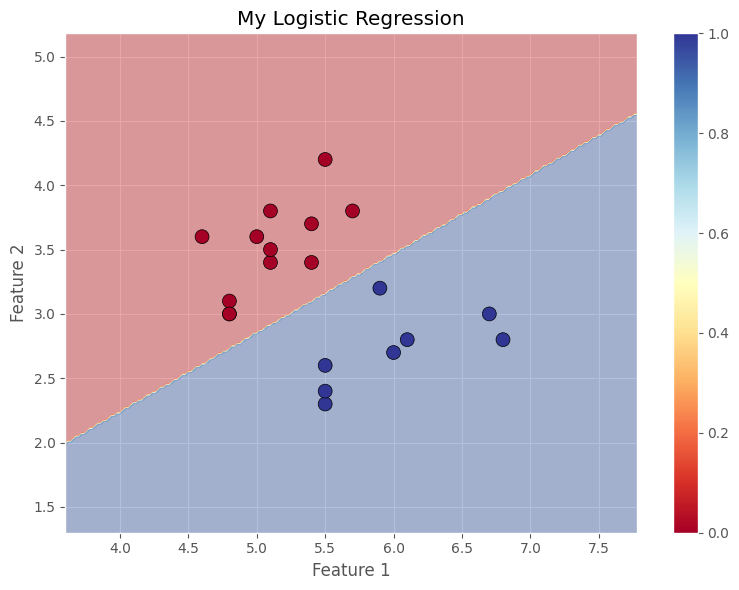

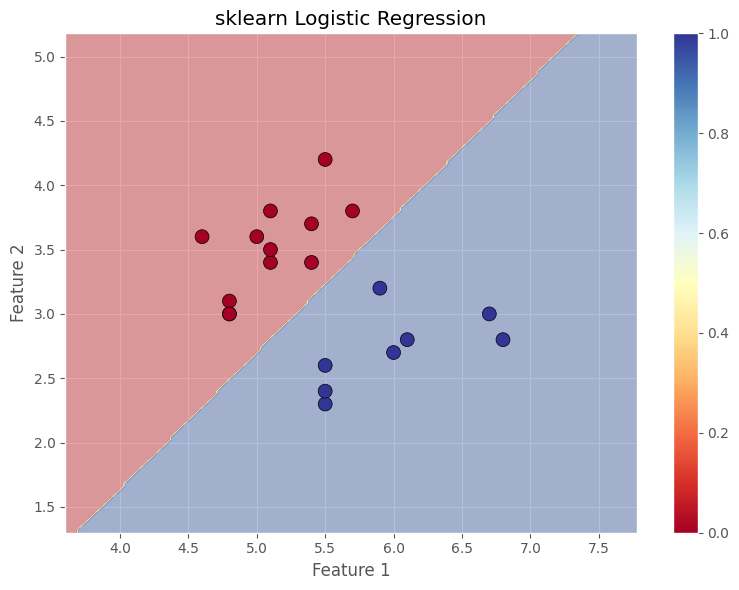

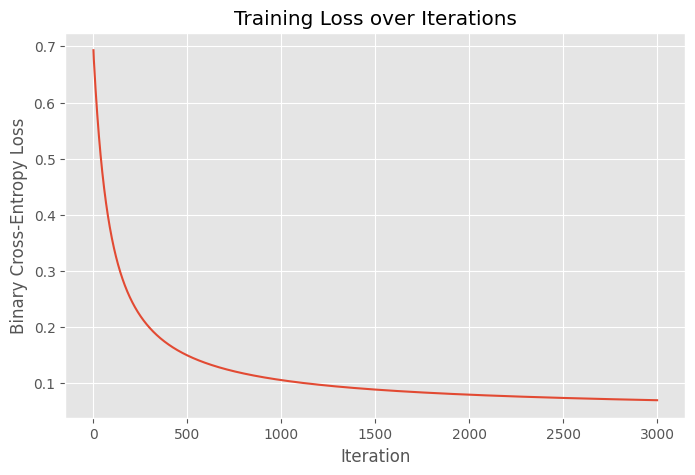

In [29]:
# Skeleton for TODO 8 (continued)

# Train your implementation
# ... your code here ...
iris = load_iris()
X = iris.data[iris.target != 2][:, :2] 
y = iris.target[iris.target != 2]

# Train sklearn's logistic regression
# ... your code here ...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

my_lr = SimpleLogisticRegression(learning_rate=0.1, num_iterations=3000)
my_lr.fit(X_train, y_train)

sk_lr = LogisticRegression(max_iter=3000)
sk_lr.fit(X_train, y_train)


def get_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

my_train_acc = get_accuracy(y_train, my_lr.predict(X_train))
my_test_acc = get_accuracy(y_test, my_lr.predict(X_test))

sk_train_acc = sk_lr.score(X_train, y_train)
sk_test_acc = sk_lr.score(X_test, y_test)

print(f"{'Model':<25} | {'Train Accuracy':<15} | {'Test Accuracy':<15}")
print("-" * 60)
print(f"{'My Logistic Regression':<25} | {my_train_acc:<15.4f} | {my_test_acc:<15.4f}")
print(f"{'sklearn LogisticRegression':<25} | {sk_train_acc:<15.4f} | {sk_test_acc:<15.4f}")


def plot_decision_boundary(X, y, model, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_decision_boundary(X_test, y_test, my_lr, 'My Logistic Regression')
plot_decision_boundary(X_test, y_test, sk_lr, 'sklearn Logistic Regression')

# plot_decision_boundary(X_test, y_test, my_lr, 'My Logistic Regression')
# ...

# Plot loss curve
# ... your code here ...
plt.figure(figsize=(8, 5))
plt.plot(my_lr.loss_history)
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True)
plt.show()

# Answer: Why do we use the sigmoid function in logistic regression?
# ...

The sigmoid function is used in logistic regression because it maps any real-valued input to a value between 0 and 1, which allows the output to be interpreted as a probability.